Building prefix dict from the default dictionary ...                (0 + 4) / 4]
Loading model from cache /tmp/jieba.cache
Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 2.695 seconds.
Prefix dict has been built successfully.
Loading model cost 2.691 seconds.
Prefix dict has been built successfully.
Loading model cost 3.067 seconds.
Prefix dict has been built successfully.
Loading model cost 3.623 seconds.
Prefix dict has been built successfully.


主題 0:
  投票: 0.011563749311714035
  選舉: 0.008104387417855251
  投開票: 0.006000765295540028
  開票: 0.005217442039665722
  生長: 0.004903166237966426
  選票: 0.004368675232391706
  台灣: 0.004002042470299824
  咖啡: 0.003939268037150904
  總統: 0.0036109549430087674
  植物: 0.0032495615286224854
主題 1:
  地震: 0.01316924906355609
  地球: 0.006726467844647748
  台灣: 0.005833755456445542
  死亡率: 0.005363560456508651
  英國: 0.004169398036180985
  專家: 0.004092392472858278
  疫苗: 0.004068166703502226
  機器: 0.003750522433556713
  影像: 0.003656791744691115
  毒品: 0.0032600129373331612
主題 2:
  台灣: 0.012541214070065358
  美國: 0.010903457570610918
  中國: 0.006410700275148626
  媒體: 0.006107350584028743
  病毒: 0.004671270160879169
  政府: 0.004553083663674215
  日本: 0.004117377719449414
  公司: 0.004022538476937954
  新聞: 0.0037901690834697558
  烏克蘭: 0.0037756327722009574
主題 3:
  疫苗: 0.018407831402936625
  病毒: 0.008203223386406288
  新冠: 0.006375456930574697
  治療: 0.005717467766599174
  專家: 0.005134027661874262
  接種: 0.0049916411182646

/tmp/ipykernel_8178/3745890226.py:101: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_texts = doc_topics_pd.groupby("dominant_topic").apply(


每個主題的 Top Texts:
主題 0:
  文本: 政治與政策, 分數: 0.9991869113780445
  文本: 政治與政策, 分數: 0.9991393446737858
  文本: 政治與政策, 分數: 0.999133342256032
  文本: 政治與政策, 分數: 0.9991165119290514
  文本: 政治與政策, 分數: 0.9990555326007843
主題 1:
  文本: 環境能源, 分數: 0.9984761675489289
  文本: 生活, 分數: 0.998427863339223
  文本: 國際, 分數: 0.9982644423398048
  文本: 科學研究, 分數: 0.9982389928189136
  文本: 國際, 分數: 0.9981362910405389
主題 2:
  文本: 政治與政策, 分數: 0.999311465603575
  文本: 生活, 分數: 0.9991068609328103
  文本: 科技資安, 分數: 0.9990832588382661
  文本: 國際, 分數: 0.9990440039153655
  文本: 科技資安, 分數: 0.9989831015499956
主題 3:
  文本: 健康, 分數: 0.9996787803190278
  文本: 健康, 分數: 0.999620620986787
  文本: 健康, 分數: 0.9995477557401952
  文本: 健康, 分數: 0.9995448641977495
  文本: 健康, 分數: 0.9994899770297038
主題 4:
  文本: 政治與政策, 分數: 0.9987036546758397
  文本: 國際, 分數: 0.9986876961771011
  文本: 政治與政策, 分數: 0.9986415789504923
  文本: 國際, 分數: 0.9985927729861858
  文本: 政治與政策, 分數: 0.9985752922438991
配對: Topic_0 - Topic_1, 權重: 0.0812824081970708
配對: Topic_0 - Topic_2, 權重: 0.1488786757333171
配對: T

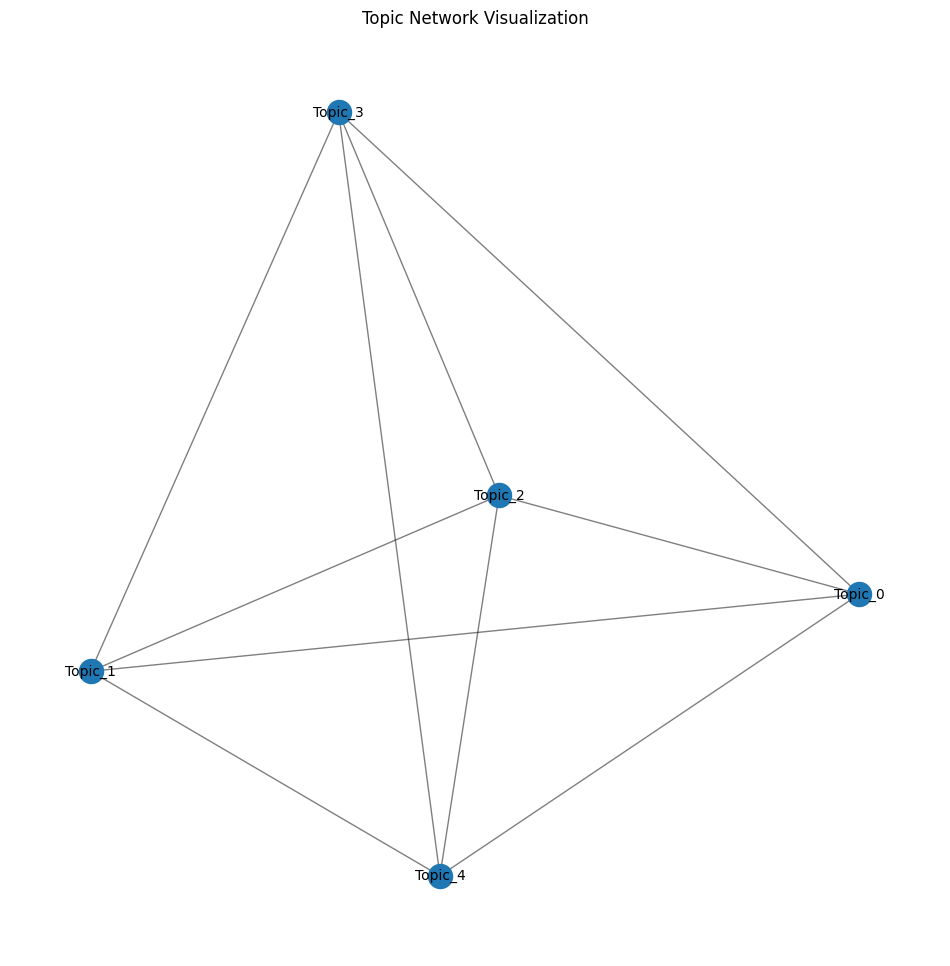

In [23]:
import os
import jieba
import re
from pyspark.sql import SparkSession
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.clustering import LDA
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from community import community_louvain
import matplotlib.colors as mcolors

# 初始化 SparkSession
spark = SparkSession.builder \
    .appName("PySpark LDA Analysis with Gephi Export") \
    .getOrCreate()

# 自定義分詞函數並去除標點符號和非中文字符
def jieba_tokenize(text):
    text = re.sub(r"[^\u4e00-\u9fa5]", "", text)  # 只保留中文字符
    return list(jieba.cut(text))

# 讀取 CSV 文件
csv_path = "/home/rrrrryeedie/final_sorted_output.csv"
data = spark.read.csv(csv_path, header=True, inferSchema=True)

# 篩選需要的欄位，例如 'title' 和 'body'
data = data.select('title', 'body').dropna()

# 停用詞處理（自定義更多停用詞）
stopwords = set([
    '的', '了', '在', '是', '和', '也', '有', '我', '他', '她', '它', '就', '都', '很', '而', '但', '不', '這', '那',
    '與', '為', '個', '被', '與', '對', '和', '或', '能', '要', '更', '來', '看', '和', '而且', '是', '你', '我們', '她們',
    '會', '查核', '說', '表示', '於', '打', '影片', '網傳', '月', '年',
    '傳言', '年月日', '照片', '指出', '可能', '等', '可以', '吃', '因此', '所', '日', '製', '後', '目前', '報導',
    '到', '使用', '畫面', '事件', '發布', '人', '中心', '報告', '發生', '造成', '社群', '平台', '規定', '內容', '文章', '圖', '傳', '事實', '是否',
    '之', '以上', '流傳', '上', '及', '錯誤', '從', '若', '檢視', '更新版', '近期', '該', '一', '二','圖片', '網站' , '如果', '不會','可','讓','隨時','更新',
    '找到','出現', '原始', '背景','誤訊息', '沒', '沒有', '多', '影響','以','長','錯','再','用','中','不是','含有','隻','日期','報告將','因為', 
    '較', '部分', '相關', '並非', '歲', '反應', '已','宣稱','處理', '流傳訊息', '反','均','建議','者','時','資料','效果','快','顯示','不要','拍','元',
    '不同','未','至', '指稱','進行','由','稱','文字','比','搭配','無法','需要','增加','訊息','一網','通過', '含量', '擷圖', '字', '事故','喝',
    '軍','研究', '高','根據','才','應','編號','方式','提醒','功能','文件','一段','戴','篩','請','罰','管理','鈣','新','鍰','黃','三','申請',
    '結果','第條', '陳','處','此','蔡','英文','書', '版本','不能','狀況','相同','提供','活動','時間','搜','貼','無關','措施'
])

def process_text(text):
    if text is None:
        return []
    words = jieba.cut(re.sub(r"[^\u4e00-\u9fa5]", "", text))
    return [word for word in words if word not in stopwords]

# 定義分詞與去停用詞的 UDF
process_text_udf = udf(process_text, ArrayType(StringType()))
data = data.withColumn("filtered_words", process_text_udf(data["body"]))

# 設置 CountVectorizer
vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="features", vocabSize=5000, minDF=5)
vectorized_model = vectorizer.fit(data)
vectorized_data = vectorized_model.transform(data)

# 設置 LDA 模型
lda = LDA(k=5, maxIter=10, featuresCol="features")
lda_model = lda.fit(vectorized_data)

# 取得主題描述
topics = lda_model.describeTopics(10)
topics_pd = topics.toPandas()

# 提取關鍵詞對應的字詞
vocab_list = vectorized_model.vocabulary
topics_pd["terms"] = topics_pd["termIndices"].apply(lambda indices: [vocab_list[idx] for idx in indices])

# 新增打印關鍵詞和權重的程式碼
for i, row in topics_pd.iterrows():
    print(f"主題 {i}:")
    for term, weight in zip(row["terms"], row["termWeights"]):
        print(f"  {term}: {weight}")

# 將文檔主題分佈轉為 NumPy 矩陣
doc_topics = lda_model.transform(vectorized_data)
doc_topics_pd = doc_topics.select("title", "topicDistribution").toPandas()
doc_topics_pd["topicDistribution"] = doc_topics_pd["topicDistribution"].apply(
    lambda x: np.array(x, dtype=np.float64)
)

# 找到每篇文檔的主要主題
doc_topic_matrix = np.array(doc_topics_pd["topicDistribution"].tolist())
doc_topics_pd["dominant_topic"] = np.argmax(doc_topic_matrix, axis=1)

# 新增 dominant_score 欄位，提取每篇文檔的主要主題分數
doc_topics_pd["dominant_score"] = doc_topics_pd.apply(
    lambda row: row["topicDistribution"][row["dominant_topic"]], axis=1
)

# 按主題分組並提取前 5 篇文本
def extract_top_texts(doc_topics_pd):
    try:
        top_texts = doc_topics_pd.groupby("dominant_topic").apply(
            lambda df: df.sort_values(by="dominant_score", ascending=False).head(5) # 顯示最重要的
        )
        print("每個主題的 Top Texts:")
        for topic, group in top_texts.groupby(level=0):
            print(f"主題 {topic}:")
            for _, row in group.iterrows():
                print(f"  文本: {row['title']}, 分數: {row['dominant_score']}")
    except Exception as e:
        print(f"提取 Top Texts 時出現錯誤: {e}")

extract_top_texts(doc_topics_pd)

# 確保 topic_names 的長度與矩陣維度一致
topic_names = [f"Topic_{i}" for i in range(doc_topic_matrix.shape[1])]

# 修正後的網絡圖生成函數
def create_topic_network(theta_matrix, topic_names, weight_threshold=0.1):
    """
    創建主題網絡圖
    :param theta_matrix: 主題分佈矩陣 (文檔 x 主題)
    :param topic_names: 主題名稱列表
    :param weight_threshold: 權重閾值，僅顯示大於此閾值的邊
    :return: NetworkX Graph
    """
    # 檢查 theta_matrix 的維度和 topic_names 是否匹配
    if len(topic_names) != theta_matrix.shape[1]:
        raise ValueError("topic_names 的長度與主題矩陣的列數不匹配！")

    # 計算主題間的餘弦相似度
    cosine_sim = cosine_similarity(theta_matrix.T)  # 矩陣需轉置
    G = nx.Graph()

    # 創建圖結構
    for i in range(len(cosine_sim)):
        for j in range(i + 1, len(cosine_sim)):
            if cosine_sim[i, j] > weight_threshold:  # 設定權重閾值
                print(f"配對: {topic_names[i]} - {topic_names[j]}, 權重: {cosine_sim[i, j]}")
                G.add_edge(topic_names[i], topic_names[j], weight=cosine_sim[i, j])

    # 使用 Louvain 方法進行社群檢測
    partition = community_louvain.best_partition(G)
    nx.set_node_attributes(G, partition, 'community')
    return G

# 修正後的網絡視覺化函數
def visualize_network(G):
    """
    視覺化主題網絡圖，基於社群使用不同顏色
    :param G: NetworkX Graph
    """
    pos = nx.spring_layout(G)  # 使用 spring layout 佈局
    plt.figure(figsize=(12, 12))

    communities = nx.get_node_attributes(G, 'community')
    unique_communities = set(communities.values())
    color_map = list(mcolors.TABLEAU_COLORS.values())

    for community in unique_communities:
        nodes = [node for node in G.nodes if communities[node] == community]
        nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_size=300, 
                               node_color=color_map[community % len(color_map)])

    nx.draw_networkx_edges(G, pos, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=10)
    plt.title("Topic Network Visualization")
    plt.axis('off')
    plt.show()

# 使用修正後的權重閾值生成網絡圖並視覺化
try:
    weight_threshold = 0.008
    network = create_topic_network(doc_topic_matrix, topic_names, weight_threshold=weight_threshold)
    visualize_network(network)
except Exception as e:
    print(f"出現錯誤: {e}")
